# Mini-project: Calibrated probability estimation

## Step 1: Learning a classifier

In [1]:
from sklearn.feature_extraction.text import CountVectorizer
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from pandas import read_csv
from pandas import read_fwf
from pandas import read_html
import re
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import time
import datetime
import re
import seaborn as sns
import nltk
from math import sqrt
from math import pi
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import accuracy_score, mean_squared_error,mean_absolute_error,r2_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn import metrics
from sklearn import tree
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from kneed import KneeLocator, DataGenerator
from itertools import cycle, islice
from pandas.plotting import parallel_coordinates
from wordcloud import WordCloud

%matplotlib inline

In [17]:
data = read_csv('full_set.txt', header = None, sep = '\t')
data.columns = ["sentence", "label"]
data

,sentence,label
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1
...,...,...
2743,I just got bored watching Jessice Lange take h...,0
2744,"Unfortunately, any virtue in this film's produ...",0
2745,"In a word, it is embarrassing.",0
2746,Exceptionally bad!,0


 ### Remove the labels from the sentences and store them separately.

In [3]:
df = pd.DataFrame(data = data)
sentence = df['sentence']
label = df['label']

### Remove digits and punctuation, and make everything lowercase.

In [4]:
# remove punctuations and digits
sentence_r = []
for i in sentence:#.sentence:
    sentence_r.append(re.sub("[^a-zA-Z]", " ", i))
df_sentence = pd.DataFrame(sentence_r, columns=['sentence'])

In [5]:
# Convert upper case to lower case
sentence_r_l = []
for i in range(df_sentence.sentence.shape[0]):
    sentence_r_l.append(df_sentence.sentence[i].lower())
df_sentence_r_l = pd.DataFrame(sentence_r_l, columns=['sentence'])

### Remove “stop words”, common words that are useless for classification. I suggest removing at least the following: ’the’, ’a’, ’an’, ’i’, ’he’, ’she’, ’they’, ’to’, ’of’, ’it’, ’from’.

In [6]:
text_list = []
for i in df_sentence_r_l.sentence:
    text = nltk.word_tokenize(i)
    wnl = nltk.WordNetLemmatizer()
    text = [wnl.lemmatize(word) for word in text]
    text = " ".join(text)
    text_list.append(text)

In [7]:
# Bag of words
max_features = 5000
stop_words = 'the','a','an','i','he','she','they','to','of','it','from'
count_vector = CountVectorizer(max_features = max_features, stop_words = stop_words)
sparce_matrix = count_vector.fit_transform(text_list).toarray()
all_words = count_vector.get_feature_names()

In [8]:
x = sparce_matrix
y = label
x_1 = pd.DataFrame(x)
y_1 = pd.DataFrame(y)
df = pd.DataFrame(x_1)
df[x_1.shape[1]] = y_1

In [9]:
train, calibration, test = np.split(df.sample(frac=1, random_state=42), [int(11/15*len(x)), int(13/15*len(x))])

In [10]:
df_1 = pd.DataFrame(data = train)
index = train.shape[1]
train_data = df_1.values[:,0:index-1]
train_label = df_1.values[:, -1]

df_2 = pd.DataFrame(data = test)
test_data = df_2.values[:,0:index-1]
test_label = df_2.values[:, -1]

df_3 = pd.DataFrame(data = test)
calibration_data = df_3.values[:,0:index-1]
calibration_label = df_3.values[:, -1]

## Now use sklearn.svm.LinearSVC to learn a (soft-margin) SVM, using the training set alone. You will need to set the C parameter, for which you should use cross-validation (using only the training set, of course).

In [11]:
clf_train = LinearSVC(C = 1.0, random_state = 42, tol = 1e-05)
clf_train.fit(train_data, train_label)

LinearSVC(random_state=42, tol=1e-05)

In [12]:
clf_train.score(train_data, train_label)

0.9970223325062034

## (a) Some details of the SVM training procedure (step 1).
In particular, plot the different values of C that you tried, and the cross-validated error estimate you got for each. What value of C did you end up using? What is the resulting error rate of the SVM classifier on the test set?

In [13]:
from sklearn.model_selection import cross_val_score
C_list = [1e-5, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]
error_list = []
for c in C_list:
    clf = LinearSVC(C = c, random_state = 42, tol = 1e-05)
    clf.fit(train_data, train_label)
    print('\nC=', c)
    error = 1 - clf.score(train_data, train_label)
    error_list.append(error)
    print('Error = ', error)
    score = cross_val_score(clf, train_data, train_label, cv = 5)
    print('score', score)


C= 1e-05
Error =  0.3096774193548387
score [0.66253102 0.68486352 0.64764268 0.67493797 0.63523573]

C= 0.01
Error =  0.0903225806451613
score [0.808933   0.77171216 0.7866005  0.79652605 0.76923077]

C= 0.1
Error =  0.02580645161290318
score [0.83870968 0.77667494 0.82382134 0.82382134 0.81141439]

C= 1
Error =  0.0029776674937965764
score [0.82382134 0.78411911 0.81141439 0.80397022 0.78908189]

C= 10
Error =  0.0
score [0.81637717 0.74937965 0.81389578 0.77915633 0.78163772]

C= 100
Error =  0.0014888337468982327
score [0.79156328 0.71960298 0.808933   0.75434243 0.76674938]

C= 1000
Error =  0.001985111662531014
score [0.78411911 0.70471464 0.808933   0.74689826 0.75930521]

C= 10000
Error =  0.001985111662531014
score [0.78411911 0.70223325 0.80397022 0.74689826 0.75930521]

C= 100000
Error =  0.0014888337468982327
score [0.78411911 0.70471464 0.80397022 0.74441687 0.7617866 ]


In [14]:
print('C = 10, error rate is the smallest, error =', np.min(error_list))

C = 10, error rate is the smallest, error = 0.0


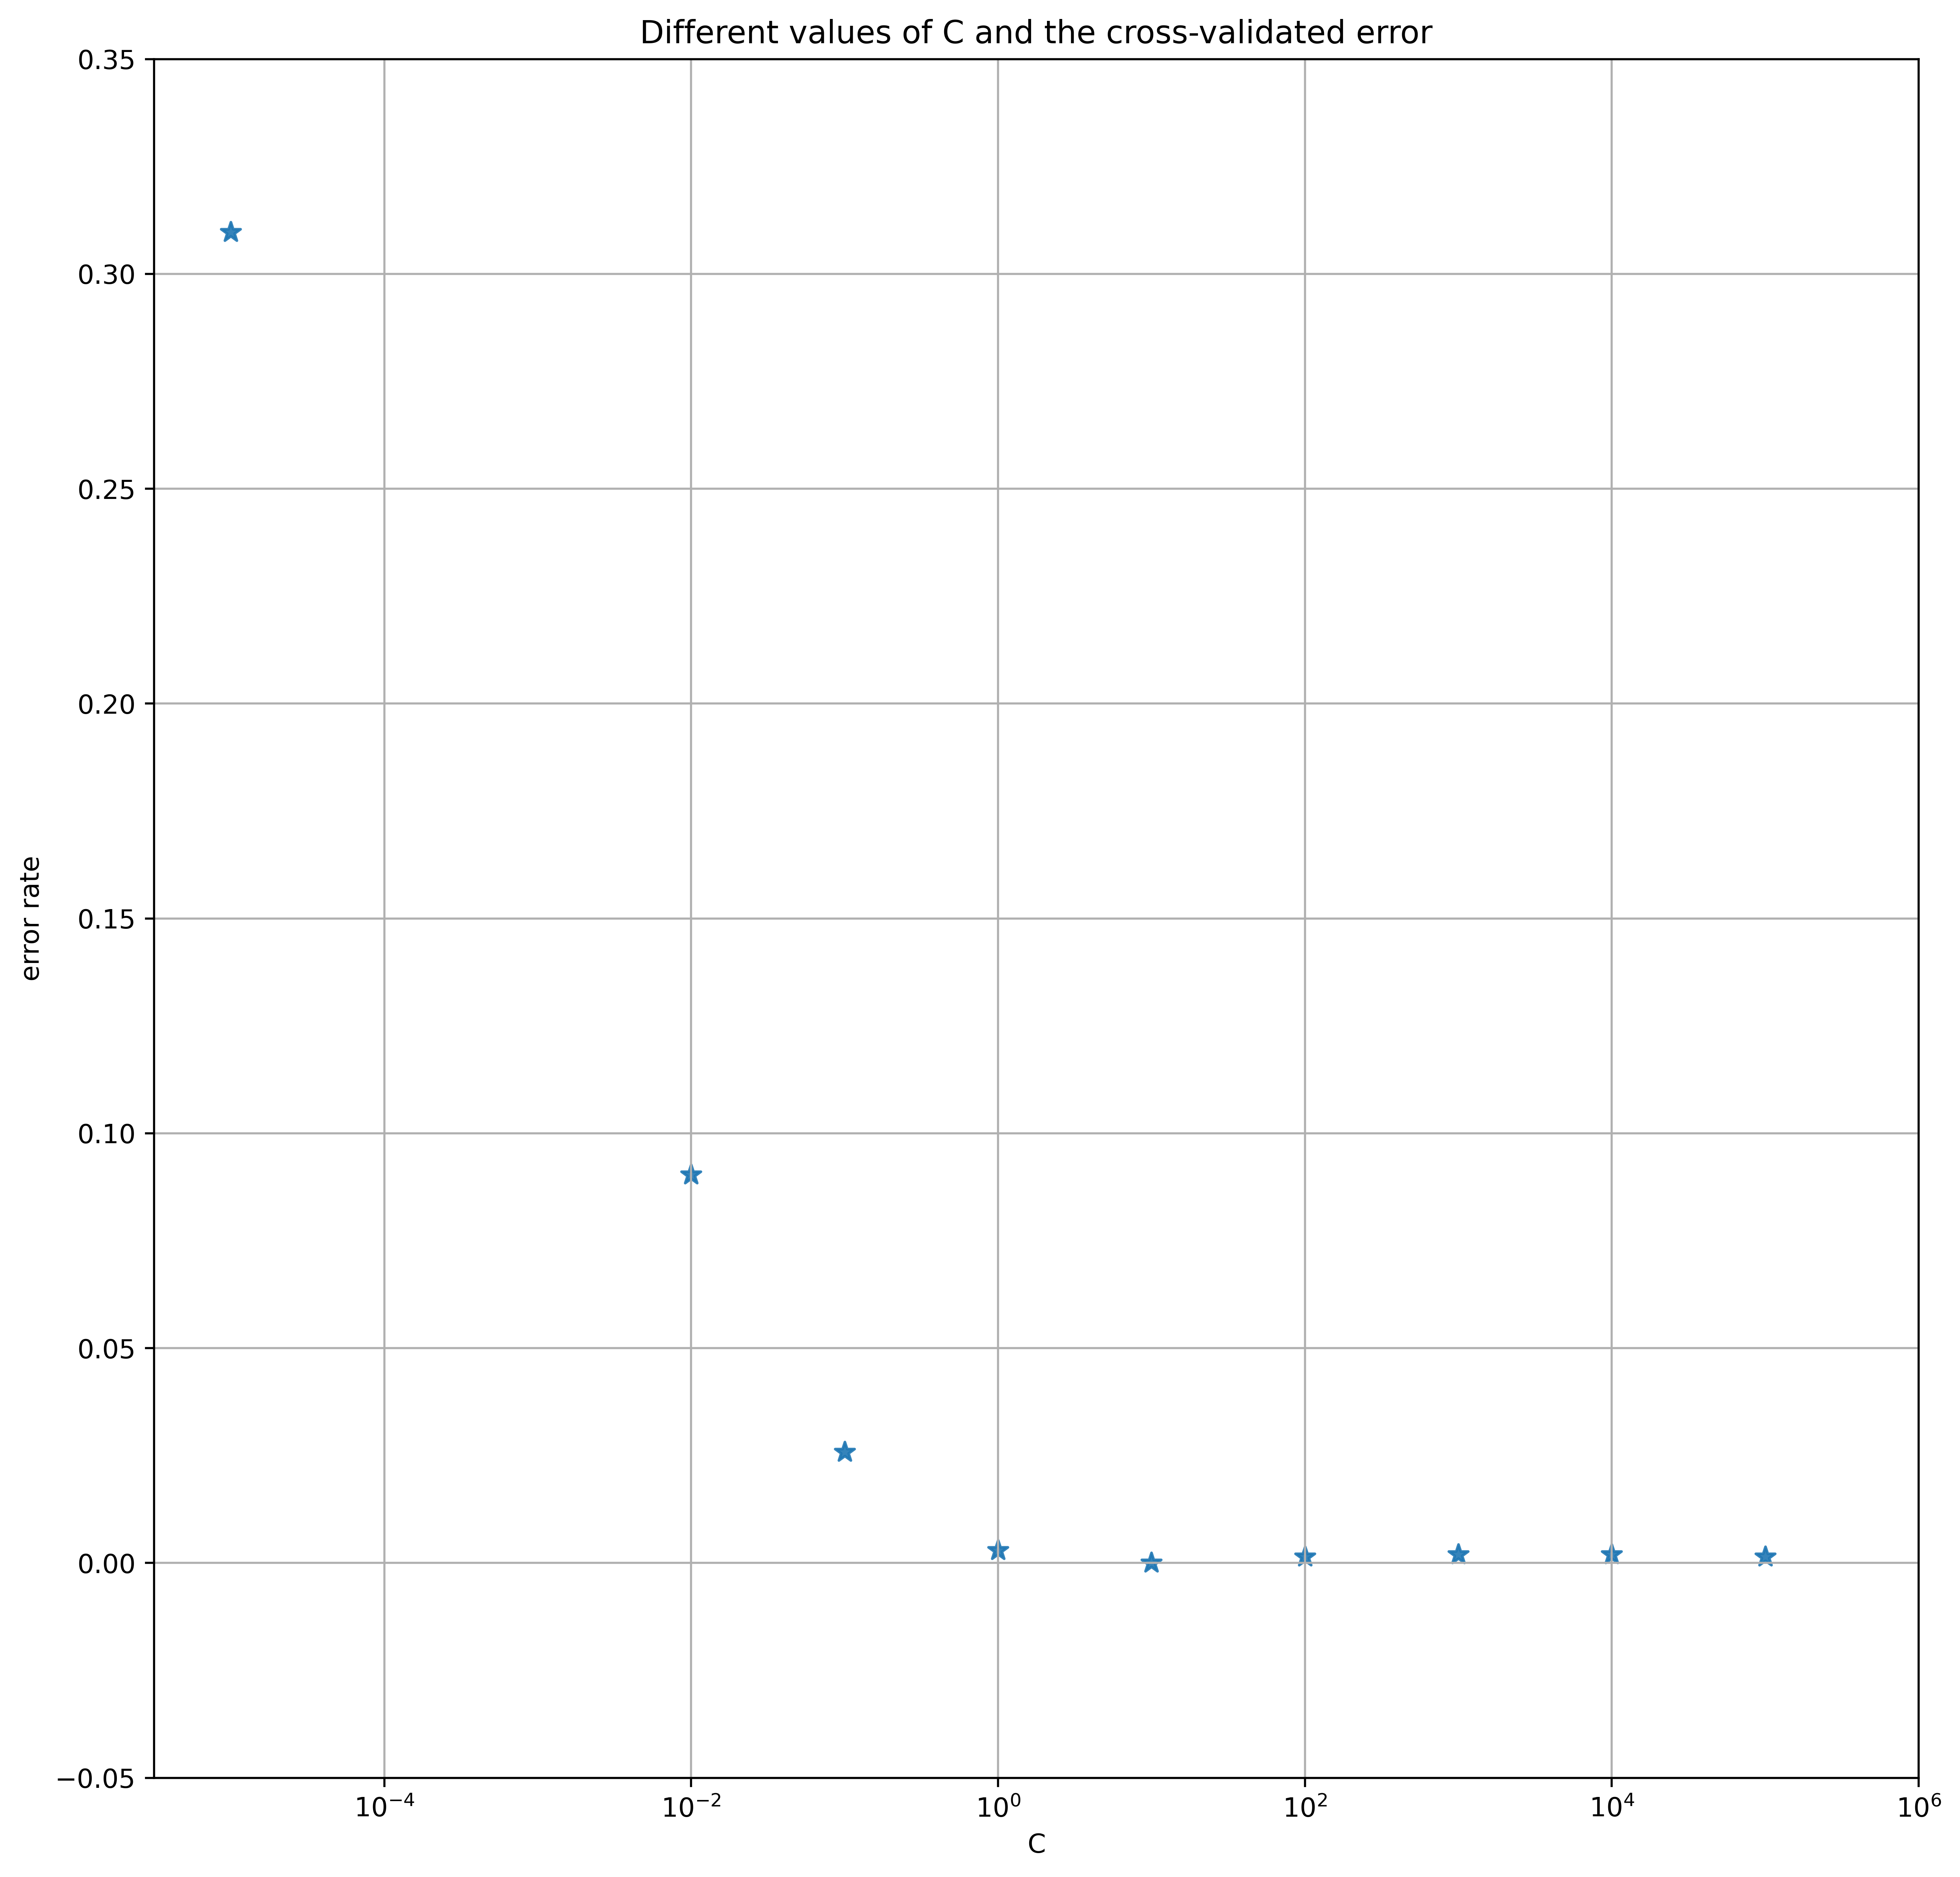

In [15]:
# Plot the data and the classification with the decision boundary.
xmin, xmax = -10000, 1000000
ymin, ymax = -0.05, 0.35

from matplotlib.pyplot import figure
figure(figsize=(12, 12), dpi=500)

plt.title('Different values of C and the cross-validated error')
plt.xlabel('C')
plt.ylabel('error rate')

plt.xscale('log')
plt.scatter(C_list, error_list, s = 60, alpha = 0.9, marker = '*')

plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

plt.grid()
plt.show()

SVC:
	Brier: 0.188
	Precision: 0.827
	Recall: 0.785
	F1: 0.805

squashing:
	Brier: 0.146
	Precision: 0.840
	Recall: 0.810
	F1: 0.825

Platt:
	Brier: 0.135
	Precision: 0.837
	Recall: 0.790
	F1: 0.813

Platt_b:
	Brier: 0.135
	Precision: 0.837
	Recall: 0.790
	F1: 0.813

Isotonic:
	Brier: 0.142
	Precision: 0.830
	Recall: 0.800
	F1: 0.815



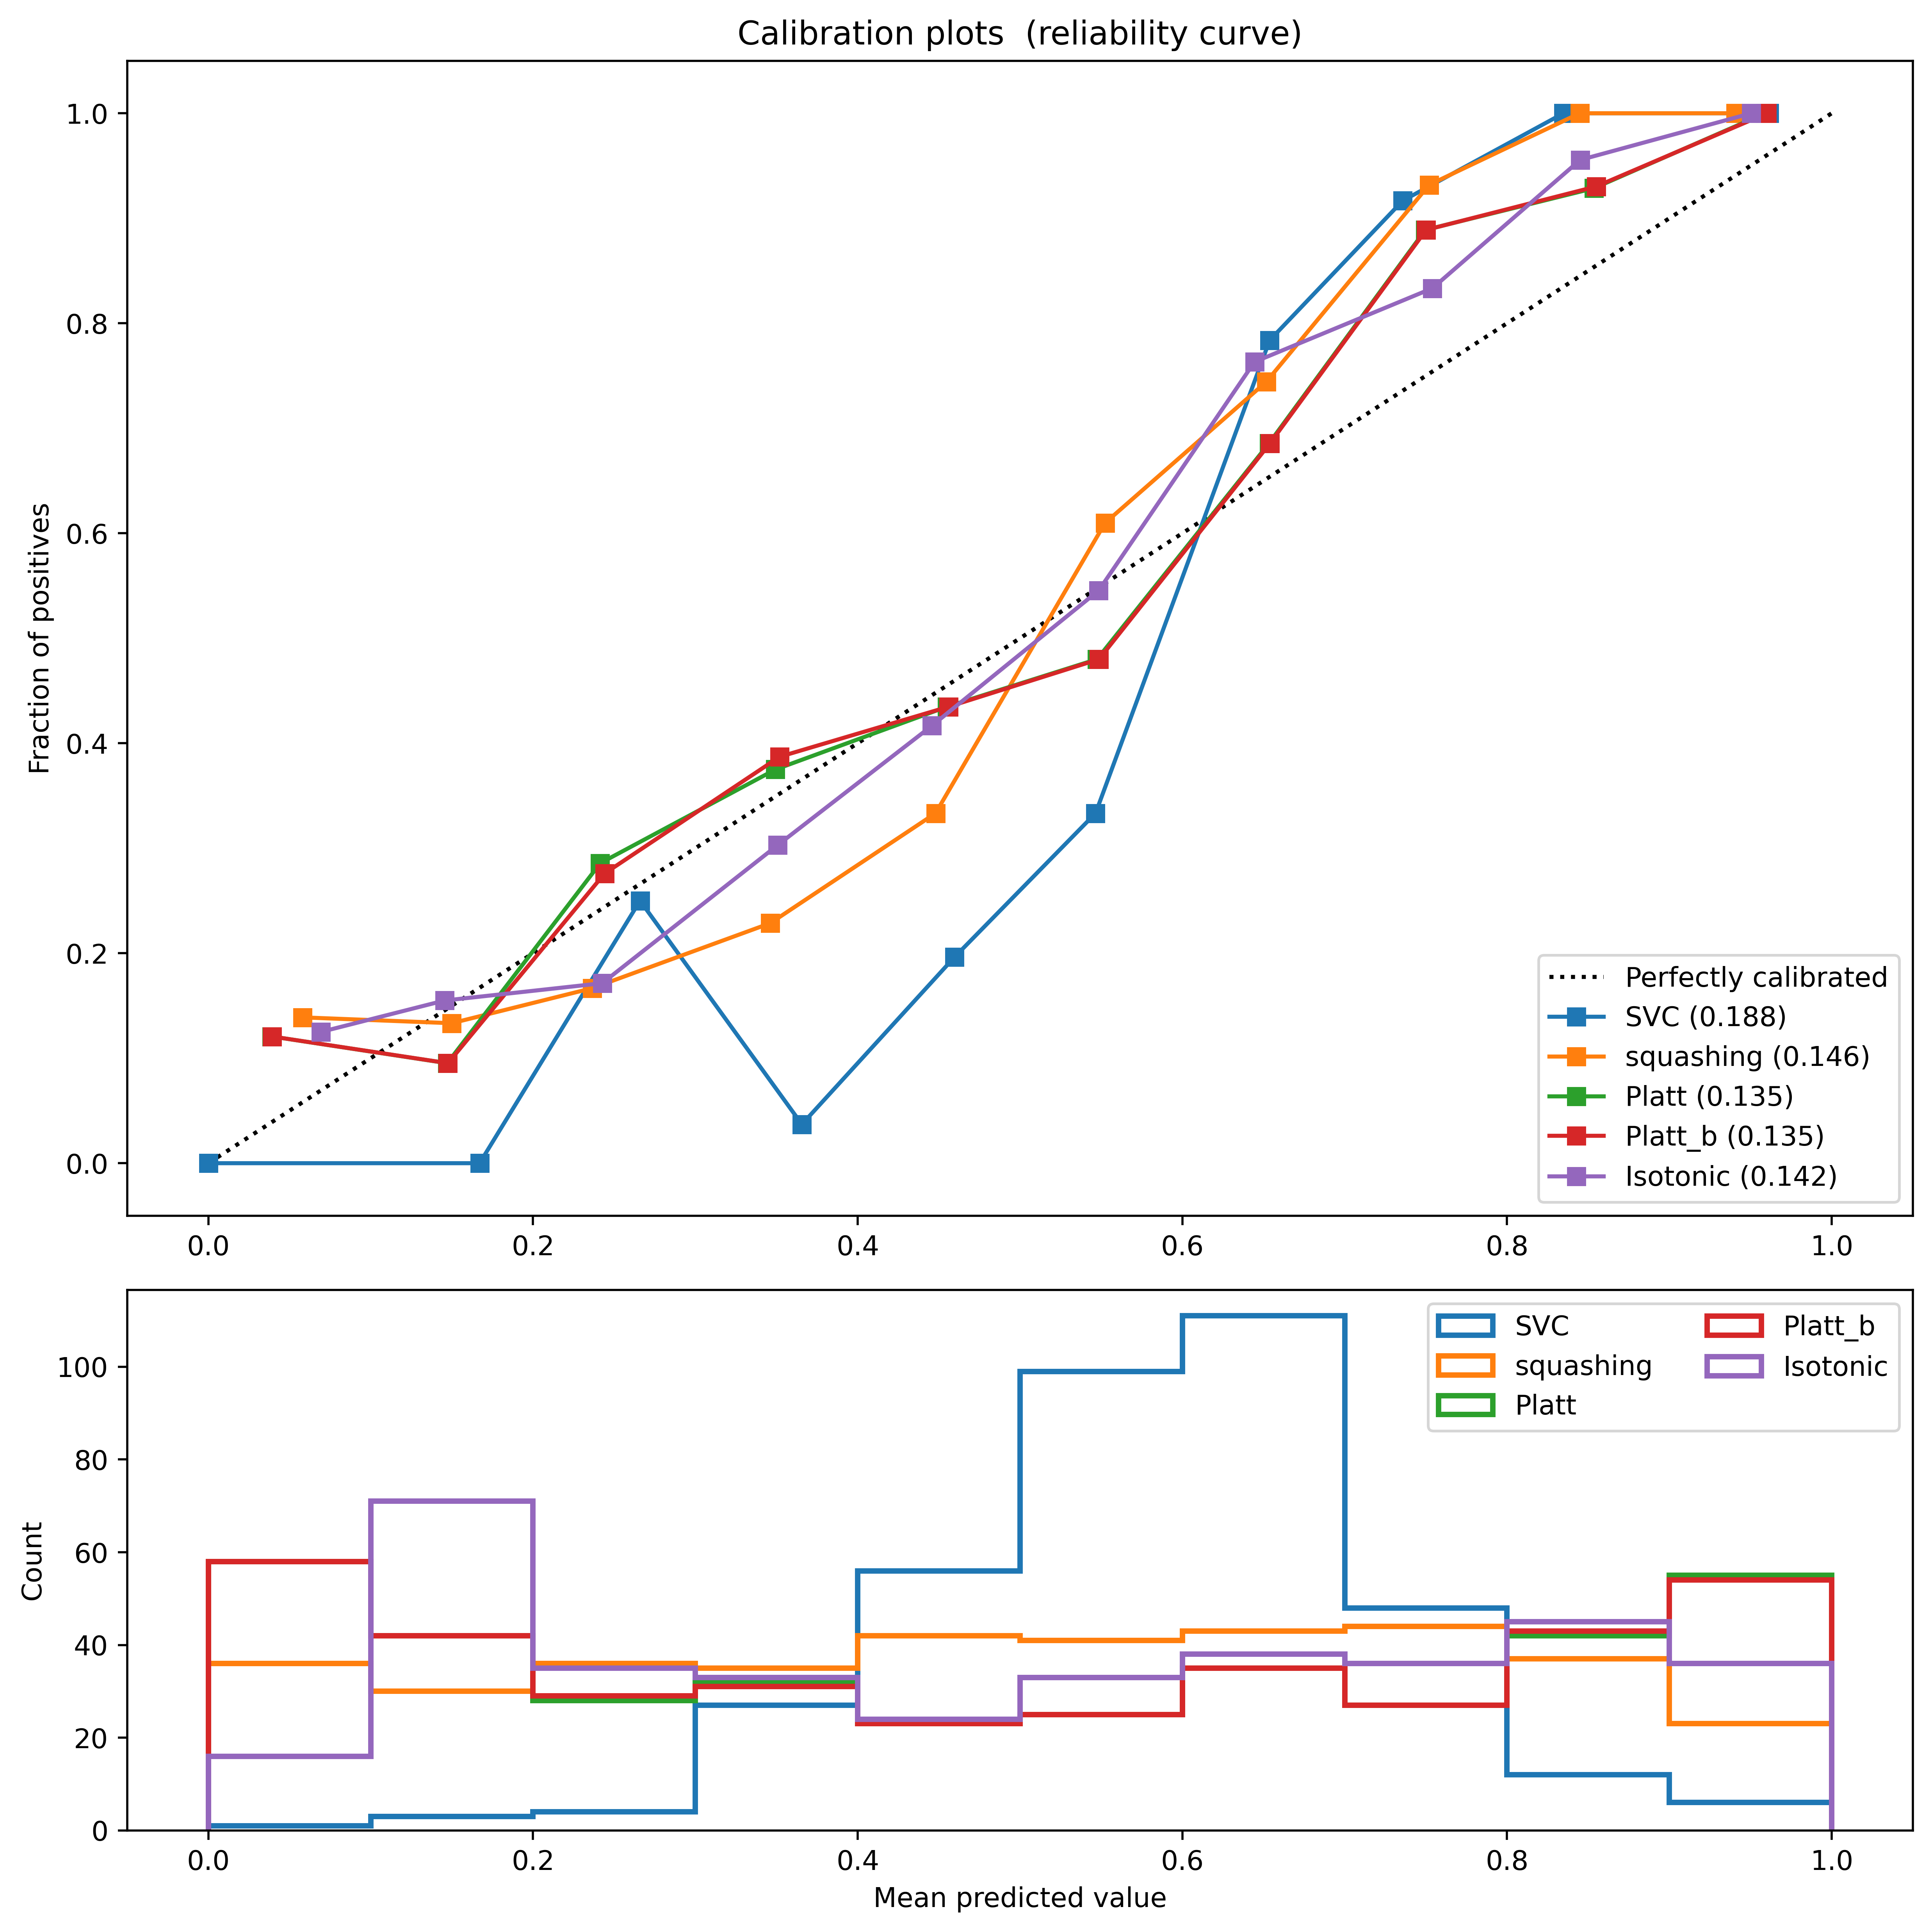

In [16]:
from sklearn import datasets
from sklearn.svm import LinearSVC
from sklearn.metrics import (brier_score_loss, precision_score, recall_score, f1_score)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.isotonic import IsotonicRegression 
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_data, test_data, train_label, test_label

def plot_calibration_curve(est, name, fig_index):
    squashing = CalibratedClassifierCV(est, cv=2, method='sigmoid')
    # intercept = 0
    lr = LogisticRegression(C=1.0)
    # intercept = 0.5
    lr_2 = LogisticRegression(C=1.0, fit_intercept = True, solver = 'liblinear', intercept_scaling = 0.5)
       
    isotonic = CalibratedClassifierCV(est, cv=2, method='isotonic')
  
    fig = plt.figure(fig_index, figsize=(10, 10), dpi=500)
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    for clf, name in [(est, name), (squashing, 'squashing'), (lr, 'Platt'), (lr_2, 'Platt_b'), (isotonic, 'Isotonic')]:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        if hasattr(clf, "predict_proba"):
            prob_pos = clf.predict_proba(X_test)[:, 1]
        else:  # use decision function
            prob_pos = clf.decision_function(X_test)
            prob_pos = (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())

        clf_score = brier_score_loss(y_test, prob_pos, pos_label=y.max())
        print("%s:" % name)
        print("\tBrier: %1.3f" % (clf_score))
        print("\tPrecision: %1.3f" % precision_score(y_test, y_pred))
        print("\tRecall: %1.3f" % recall_score(y_test, y_pred))
        print("\tF1: %1.3f\n" % f1_score(y_test, y_pred))

        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test, prob_pos, n_bins=10)

        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % (name, clf_score))

        ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
                 histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper right", ncol = 2)

    plt.tight_layout()

# Plot calibration curve for Linear SVC
plot_calibration_curve(LinearSVC(max_iter = 10000), "SVC", 2)

plt.show()

## (b) Squashing function (option 1). Show the reliability diagram (on the test set) for this. Is this calibrated? Why or why not?


1. Please refer to the above for the reliability diagram.
2. Yes, it is calibrated. Because the mean predicted value is small. The model overall appears to be reasonably well calibrated based on the actual line closely following the perfectly calibrated line.


## (c) Platt scaling (option 2). Try doing this two ways: forcing b = 0 (this is the “intercept” term) or learning b. Show the reliability diagram in each case. Which is better? Why do you think this is? Is this better calibrated than option 1?


1. Please refer to the above for the reliability diagram.

2. Learning b is better. Because b is a two scalar parameter that is learned by the algorithm, if b != 0 the probability estimates contain a correction compared to the old decision function, which helps to be better calibrated.

3. No, option 1 is better calibrated.


## (d) Isotonic regression (option 3). Show the resulting reliability diagram. How does it compare to Platt scaling?

1. Please refer to the above for the reliability diagram.

2. Compared to Platt scalling, Isotonic regression works better.


## (e) What do you consider the relative merits of Platt scaling versus isotonic regression? Would you always choose one of these over the other, or does it depend on the situation? What aspects of the learning scenario (e.g. size of calibration set) would influence your choice?

1. Platt scaling is most effective for SVMs as well as other types of classification models, which produce distorted probability distributions. It is particularly effective for max-margin methods such as SVMs, which show sigmoidal distortions in their predicted probabilities, but has less of an effect with well-calibrated models such as logistic regression. Isotonic Regression is a more powerful calibration method that can correct any monotonic distortion.

2. It depends on the situation.

3. Isotonic Regression is more prone to overfitting, and thus performs worse than Platt Scaling, when data is scarce. It works better than Platt scaling in particular when enough training data is available.


## (f) Multiclass setting. So far we have only talked about binary classification. What would calibration mean in the multiclass setting? Can you think of a way to obtain calibrated probabilities in that case?

1. It means that it can deal with classification tasks that involve more than two classes.

2. We can calibrate first for each class separately in an one-vs-rest fashion. When predicting probabilities for unseen data, the calibrated probabilities for each class are predicted separately. As those probabilities do not necessarily sum to one, a post processing is performed to normalize them.